Consider the following nonlinear programming problem below:

\begin{equation*}
\begin{aligned}
\min_{x} z = && 4x_1 && + 8x_2 && +8x_3 && + 5x_4 && + 3x_5 && + x_6 \\
s.t. && 4\frac{1}{x_1} && + 6\frac{1}{x_2}&& + 9\frac{1}{x_3} && && && +8\frac{1}{x_6}&& \leq && 106\\
 &&6\frac{1}{x_1} && + 9\frac{1}{x_2} && &&&& && + 4\frac{1}{x_6}&& \leq && 181\\
 && &&8\frac{1}{x_2} && + 5\frac{1}{x_3}&& && && +2\frac{1}{x_6}&& \leq && 190\\
 && && && && 2\frac{1}{x_4}&& + 2\frac{1}{x_5} && + 8\frac{1}{x_6} && \leq && 100\\
  && && && && && && x_1,x_2,\ldots,x_6 && \leq && 100\\
  && && && && && && x_1,x_2,\ldots,x_6 && \geq && 0.1
\end{aligned}
\end{equation*}

**Subproblem 1**

\begin{equation*}
\begin{aligned}
\min_{x} z = && 4x_1 && + 8x_2 && +8x_3 && + 5x_4 && + 3x_5 && \\
s.t. && 4\frac{1}{x_1} && + 6\frac{1}{x_2}&& + 9\frac{1}{x_3} && && && +8\frac{1}{x_6}&& \leq && 106\\
 &&6\frac{1}{x_1} && + 9\frac{1}{x_2} && &&&& && + 4\frac{1}{x_6}&& \leq && 181\\
 && &&8\frac{1}{x_2} && + 5\frac{1}{x_3}&& && && +2\frac{1}{x_6}&& \leq && 190\\
   && && && && && && x_6 && = && x^{(v)} && : && \textcolor{red}{\lambda_1}\\
  && && && && && && x_1,x_2,x_3 && \leq && 100\\
  && && && && && && x_1,x_2,x_3 && \geq && 0.1
\end{aligned}
\end{equation*}

**Subproblem 2**

\begin{equation*}
\begin{aligned}
\min_{x} z = && 4x_1 && + 8x_2 && +8x_3 && + 5x_4 && + 3x_5 && \\
s.t. && && && && 2\frac{1}{x_4}&& + 2\frac{1}{x_5} && + 8\frac{1}{x_6} && \leq && 100\\
   && && && && && && x_6 && = && x^{(v)} && : && \textcolor{red}{\lambda_2}\\
  && && && && && && x_4,x_5 && \leq && 100\\
  && && && && && && x_4,x_5 && \geq && 0.1
\end{aligned}
\end{equation*}

**Master problem**

\begin{equation*}
\begin{aligned}
\min_{x}&& z = \alpha + x_6\\
s.t && z_\text{subproblem 1} + z_\text{subproblem 2} - (\lambda_1 + \lambda_2)(x_6 - x^{(v)}) && \leq && \alpha \\
&& x_6 && \geq && 0.1\\
&& x_6 && \leq && 100
\end{aligned}
\end{equation*}

In [104]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)

In [105]:
random.seed(10)

#number of x or y variables
num_var = 6

#number of constraints
num_cons = 4

#tolerance
epsilon = 3

e = []
f = []
b = []
c = []
d = []

#creating variables to store x and y variables and x and y lambda
x_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

e = [[4, 6, 9, 0, 0, 8], [6, 9, 0, 0, 0, 4], [0, 8, 5, 0, 0, 2], [0, 0, 0, 2, 2, 8]]

#creating random constraint coefficients and random b vector
for i in list(range(0,num_cons)):
    b.append(random.randrange(100,200,3))

for i in list(range(0,num_var)):
    c.append(random.randrange(1,10,1))

x_value = [2]
x_vars_list = []
lam1 = []
lam2 = []
z_up1 = []
z_up2 = []
z_down = [-100]
cuts = 1

iteration = 0

In [106]:
def subproblem_1(x_value):    
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(num_var)
    model.J = RangeSet(num_cons-1)

    model.x = Var(model.I, domain = NonNegativeReals, bounds = (0.1,100))

    def obj_rule(model):
        return sum(model.x[i]*c[i-1] for i in model.I if i not in (4,5))
    model.obj = Objective(rule = obj_rule)

    def cons_rule(model,j):
        return sum((1/model.x[i])*e[j-1][i-1] for i in model.I if i not in (4,5)) <= b[j-1]

    model.cons = Constraint(model.J, rule = cons_rule)
    model.bind_cons = Constraint(expr = model.x[6] == x_value[iteration])
    
    opt = SolverFactory('ipopt', executable = 'C:/Users/Faisal Ahmed/ipopt.exe')

    result_obj = opt.solve(model)

    #model.pprint()

    z_up1.append(value(model.obj))
    lam1.append(value(model.dual[model.bind_cons]))

    x_vars_list.append([value(model.x[i]) for i in model.I if i not in (4,5,6)])

In [107]:
def subproblem_2(x_value):    
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(num_var)

    model.x = Var(model.I, domain = NonNegativeReals, bounds = (0.1,100))

    def obj_rule(model):
        return sum(model.x[i]*c[i-1] for i in model.I if i not in (1,2,3))
    model.obj = Objective(rule = obj_rule)

    model.cons = Constraint(expr = 2*(1/model.x[4]) + 2*(1/model.x[5]) + 8*(1/model.x[6]) <= 100)
    model.bind_cons = Constraint(expr = model.x[6] == x_value[iteration])
    
    opt = SolverFactory('ipopt', executable = 'C:/Users/Faisal Ahmed/ipopt.exe')

    result_obj = opt.solve(model)

    #model.pprint()

    z_up2.append(value(model.obj))
    lam2.append(value(model.dual[model.bind_cons]))

    for i in model.I:
        if i not in (1,2,3):
            x_vars_list[-1].append(value(model.x[i]))

In [108]:
def master_problem(cuts, x_value, z_up):
    model = ConcreteModel()

    model.I = RangeSet(num_var)
    model.J = RangeSet(num_cons)
    model.K = RangeSet(cuts)

    model.alpha = Var(domain = Reals)
    model.x_value = Var(domain = NonNegativeReals, bounds = (0.1, 100))
    
    model.obj = Objective(expr = model.alpha + model.x_value)

    def cons_rule(model,k):
        return z_up[k-1] + (lam1[k-1] + lam2[k-1])*(model.x_value - x_value[k-1]) <= model.alpha
    
    model.cons = Constraint(model.K ,rule = cons_rule)

    opt = SolverFactory('gurobi')

    result_obj = opt.solve(model)

    #model.pprint()

    z_down.append(value(model.alpha))
    x_value.append(value(model.x_value))

In [109]:
convergence = False
while convergence == False:

    subproblem_1(x_value)
    subproblem_2(x_value)
    
    z_up = [z_up1[i] + z_up2[i] for i in range(len(z_up1))]

    if abs((z_up[-1] - z_down[-1]))/abs(z_down[-1]) < 10e-7:
        convergence = True
        break

    master_problem(cuts, x_value, z_up)

    cuts += 1
    iteration +=1        

In [110]:
x = []
diff = []
for i in list(range(1,num_var+1)):
     x.append("x"+str(i)+"")

for i in list(range(0,len(z_down))):
     diff.append(abs(z_up[i] - z_down[i])/abs(z_down[i]))

x_dat = pd.DataFrame(x_vars_list, columns=x)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
alpha_dat = pd.DataFrame(z_down, columns =['\u03B1'])
z_up_dat = pd.DataFrame(z_up, columns = ["Z_up"])
z_down_dat = pd.DataFrame(z_down, columns =["Z_down"])
diff_dat = pd.DataFrame(diff, columns = ['Diff'])

pd.concat([x_dat, alpha_dat,lam1_dat, lam2_dat,z_up_dat,z_down_dat, diff_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,α,λ1,λ2,Z_up,Z_down,Diff
0,0.190328,0.164829,0.201874,0.1,0.1,2.0,-100.000000,-0.927550,-1.000000,8.494935,-100.000000,1.084949e+00
1,0.183284,0.158729,0.194402,0.1,0.1,100.0,-180.404993,-1.002479,-1.002506,204.358189,-180.404993,2.132775e+00
2,0.183284,0.158729,0.194402,0.1,0.1,100.0,204.358189,-1.002479,-1.002506,204.358189,204.358189,1.390779e-16


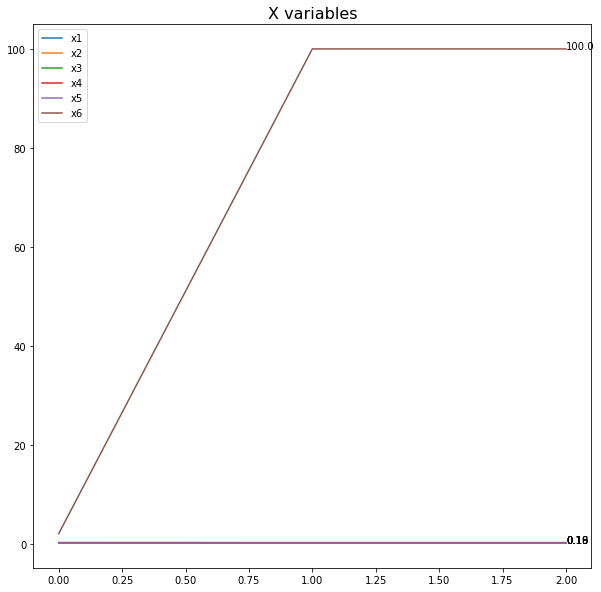

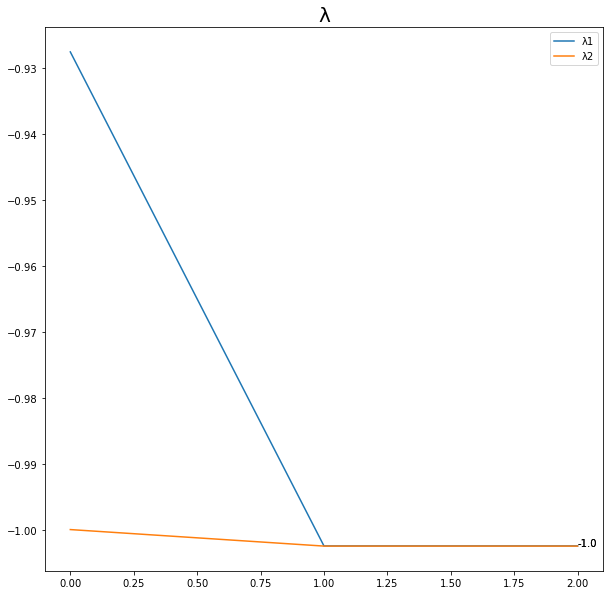

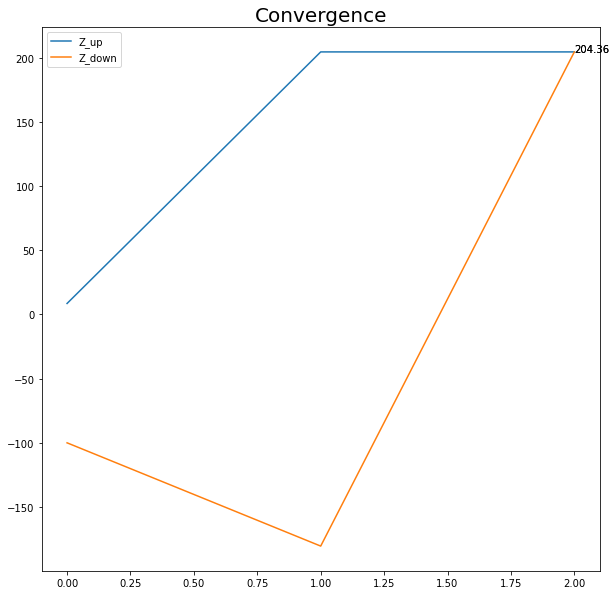

In [111]:
plt.plot(x_vars_list, label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
for i in [iteration]:
    for j in list(range(0,len(x_vars_list[0]))):
        plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
        plt.legend();
plt.show()

plt.plot(lam1, label = "\u03BB1"); #suppress matpolotlib output
for i in [iteration]:
    plt.text(list(range(0,len(lam1)))[i],lam1[i],str(round(lam1[i],2)))

plt.plot(lam2, label = "\u03BB2"); #suppress matpolotlib output
for i in [iteration]:
    plt.text(list(range(0,len(lam2)))[i],lam2[i],str(round(lam2[i],2)))

plt.title("\u03BB", fontsize = 20)
plt.legend();
plt.show()

plt.plot(z_up, label = "Z_up"); #suppress matpolotlib output
plt.plot(z_down, label = "Z_down"); #suppress matpolotlib output

for i in [iteration]:
    plt.text(list(range(0,len(z_up)))[i],z_up[i],str(round(z_up[i],2)))
    plt.text(list(range(0,len(z_down)))[i],z_down[i],str(round(z_down[i],2)))
plt.title("Convergence", fontsize = 20)
plt.legend();
plt.show()

In [112]:
model = ConcreteModel()

model.dual = Suffix(direction = Suffix.IMPORT)

model.I = RangeSet(1,num_var)
model.J = RangeSet(1,num_cons)

model.x = Var(model.I, domain = NonNegativeReals, bounds = (0.1,100))

def obj_rule(model):
    return sum(model.x[i]*c[i-1] for i in model.I)
model.obj = Objective(rule = obj_rule)

def cons_rule(model,j):
    return sum((1/model.x[i])*e[j-1][i-1] for i in model.I) <= b[j-1]

model.cons = Constraint(model.J, rule = cons_rule)

opt = SolverFactory('ipopt', executable = 'C:/Users/Faisal Ahmed/ipopt.exe')

result_obj = opt.solve(model)

#model.pprint()

value(model.obj)

5.467005968773851